# Preprocesamiento

## Leer y procesar base de datos

De la base de datos tenemos la siguiente información sobre los atributos:
   1. __survival__: the number of months patient survived (has survived, if patient is still alive).  Because all the patients had their heart attacks at different times, it is possible that some patients have survived less than one year but they are still alive.  Check the second variable to confirm this.  Such patients cannot be used for the prediction task mentioned above.
   
   2. __still-alive__: a binary variable.  0 means dead at end of survival period, 1 means still alive
   3. __age-at-heart-attack__: age in years when heart attack occurred
   4. __pericardial-effusion__: binary. Pericardial effusion is fluid around the heart.  0=no fluid, 1=fluid
   5. __fractional-shortening__: a measure of contracility around the heart lower numbers are increasingly abnormal
   6. __epss__: E-point septal separation, another measure of contractility. Larger numbers are increasingly abnormal.
   7. __lvdd__: left ventricular end-diastolic dimension.  This is a measure of the size of the heart at end-diastole. Large hearts tend to be sick hearts.
   8. __wall-motion-score__: a measure of how the segments of the left ventricle are moving
   9. __wall-motion-index__: equals wall-motion-score divided by number of segments seen.  Usually 12-13 segments are seen in an echocardiogram.  Use this variable INSTEAD of the wall motion score.
   10. __mult__: a derivate var which can be ignored
   11. __name__: the name of the patient (I have replaced them with "name")
   12. __group__: meaningless, ignore it
   13. __alive-at-1__: Boolean-valued. Derived from the first two attributes. 0 means patient was either dead after 1 year or had been followed for less than 1 year.  1 means patient was alive at 1 year.


Leemos el archivo `*.data` y lo guardamos en un *data frame*

In [6]:
import numpy as np
import pandas as pd

names = ['survival', 'still_alive', 'age_at_heart_attack', 'pericardial_effusion',
         'fractional_shortening', 'epss', 'lvdd', 'wall_motion_score',
         'wall_motion_index', 'mult', 'name', 'group', 'alive_at_1']
data = pd.DataFrame(np.genfromtxt('../data/echocardiogram.data', delimiter=','), columns=names)
print(data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 132 entries, 0 to 131
Data columns (total 13 columns):
survival                 130 non-null float64
still_alive              131 non-null float64
age_at_heart_attack      127 non-null float64
pericardial_effusion     131 non-null float64
fractional_shortening    124 non-null float64
epss                     117 non-null float64
lvdd                     121 non-null float64
wall_motion_score        128 non-null float64
wall_motion_index        131 non-null float64
mult                     128 non-null float64
name                     0 non-null float64
group                    110 non-null float64
alive_at_1               74 non-null float64
dtypes: float64(13)
memory usage: 13.5 KB
None


Como vemos no todas las columnas son útiles debido a la falta de valores, como la columna `names` que no contiene un solo valor de utilidad. Así eliminamos las columnas `'wall_motion_score','mult', 'name', 'group', 'alive_at_1'`.
 - La primera porque el autor lo indica.
 - Las siguientes tres no contienen información nueva o relevante.
 - La última contiene pocos, o bien le faltan muchos.
 
Luego eliminamos todas las __instancias__ que contienen `NaN` que, por lo tanto, no son útiles.

In [7]:
data = data.drop(['wall_motion_score','mult', 'name', 'group', 'alive_at_1'], axis=1)
data = data.dropna()

Graficamos la base de datos para ver posibles relaciones lineales entre atributos. 

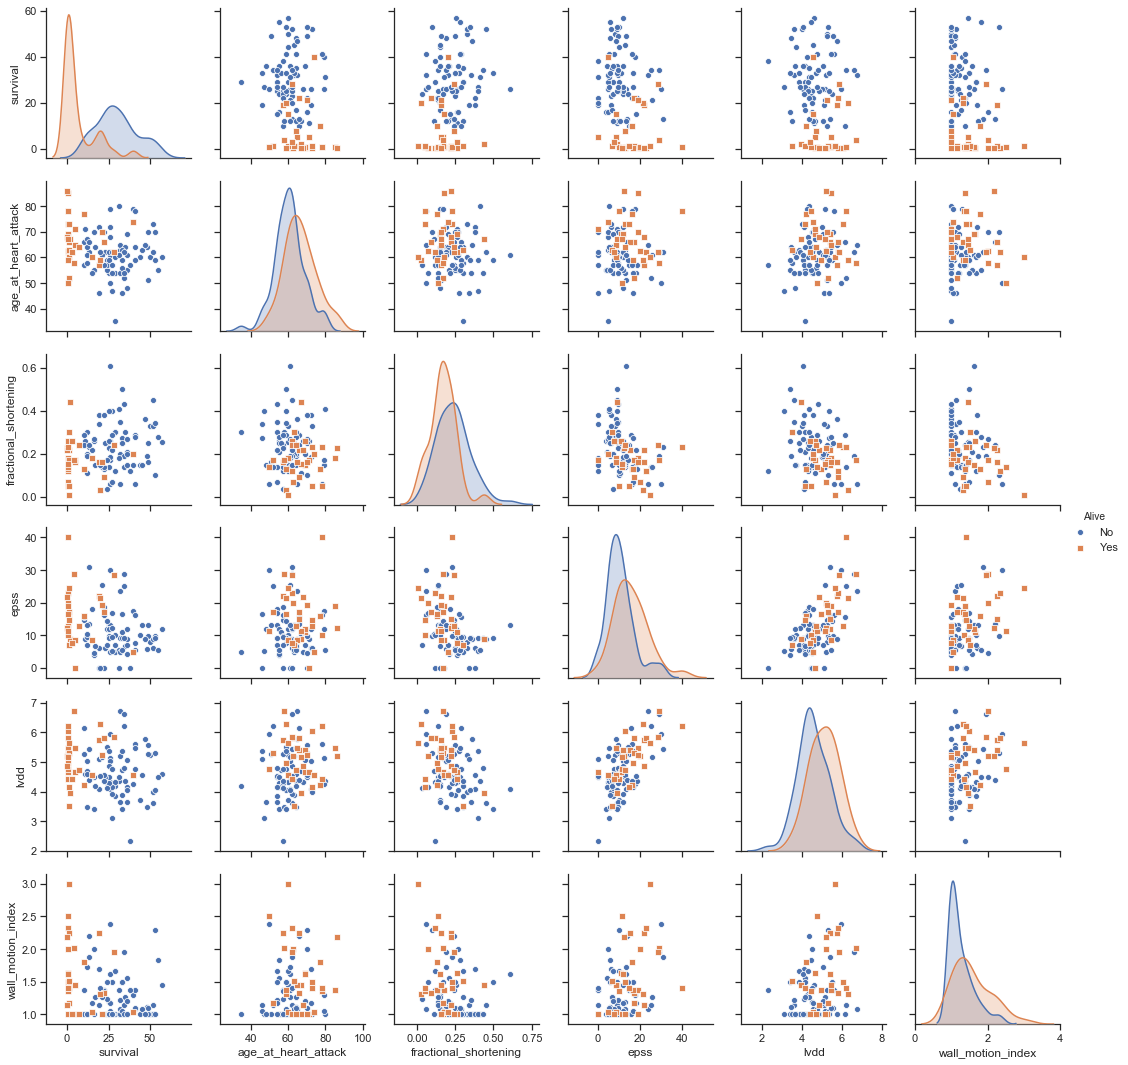

In [8]:
# Plot data_frame
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
sns.set(style="ticks")
s = sns.pairplot(data, hue='still_alive', markers=["o", "s"], vars=['survival', 
                'age_at_heart_attack', 'fractional_shortening','epss', 'lvdd', 'wall_motion_index'])
new_title = 'Alive'
s._legend.set_title(new_title)
new_labels = ['No', 'Yes']
for t, l in zip(s._legend.texts, new_labels): t.set_text(l)
plt.show();

## Preparar datos para entrenamiento

Como nos interesa si el paciente vivirá más del año, nos fijaremos en la columna `survival` que nos indica el número de meses que el paciente ha vivido o vivió después del infarto.

In [9]:
from sklearn.model_selection import train_test_split
x = data[['age_at_heart_attack', 'fractional_shortening', 'epss', 'lvdd', 
          'wall_motion_index', 'pericardial_effusion', 'still_alive']]
y = data[['survival']]

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, shuffle = True)

El número de nodos de entrada (o neuronas de paso) será igual al número de atributos, i.e. siete. Luego proponemos una red pequeña con tres capas de 16, 8 y 4 neuronas y una en la salida que indicará el número de meses que se pronostica vivirá el paciente.

In [11]:
n_input = 7     # input layer (7 columns/features)
n_hidden1 = 16  # 1st hidden layer
n_hidden2 = 8   # 2nd hidden layer
n_hidden3 = 4   # 3rd hidden layer
n_output = 1    # output layer (survival time)

learning_rate = 1e-4
n_iterations = 200
batch_size = 32
dropout = 0.5

In [14]:
import tensorflow as tf
X = tf.placeholder("float", [None, n_input])
Y = tf.placeholder("float", [None, n_output])
keep_prob = tf.placeholder(tf.float32) 

weights = {
    'w1': tf.Variable(tf.random.normal([n_input, n_hidden1], stddev=0.1)),
    'w2': tf.Variable(tf.random.normal([n_hidden1, n_hidden2], stddev=0.1)),
    'w3': tf.Variable(tf.random.normal([n_hidden2, n_hidden3], stddev=0.1)),
    'out': tf.Variable(tf.random.normal([n_hidden3, n_output], stddev=0.1)),
}

biases = {
    'b1': tf.Variable(tf.constant(1., shape=[n_hidden1])),
    'b2': tf.Variable(tf.constant(1., shape=[n_hidden2])),
    'b3': tf.Variable(tf.constant(1., shape=[n_hidden3])),
    'out': tf.Variable(tf.constant(1., shape=[n_output]))
}


layer_1 = tf.add(tf.matmul(X, weights['w1']), biases['b1'])
layer_2 = tf.add(tf.matmul(layer_1, weights['w2']), biases['b2'])
layer_3 = tf.add(tf.matmul(layer_2, weights['w3']), biases['b3'])
#layer_drop = tf.nn.dropout(layer_3, keep_prob)
output_layer = tf.matmul(layer_3, weights['out']) + biases['out']

cross_entropy = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=Y, logits=output_layer))
train_step = tf.train.AdamOptimizer(learning_rate).minimize(cross_entropy)

correct_pred = tf.equal(tf.argmax(output_layer, 1), tf.argmax(Y, 1))
accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32))

W0917 11:18:41.321669  1928 deprecation.py:323] From <ipython-input-14-a4ced4e62628>:27: softmax_cross_entropy_with_logits (from tensorflow.python.ops.nn_ops) is deprecated and will be removed in a future version.
Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See `tf.nn.softmax_cross_entropy_with_logits_v2`.



In [15]:
init = tf.global_variables_initializer()
sess = tf.Session()
sess.run(init)


cost_summary = tf.summary.scalar("cost",cross_entropy)
acc_summary = tf.summary.scalar("accuracy",accuracy)
# Merge all summaries
all_summary = tf.summary.merge_all()
# Summary writer
writer = tf.summary.FileWriter("Tensorboard", sess.graph)

In [ ]:
# train on mini batches
for i in range(n_iterations):
    batch_x, batch_y = mnist.train.next_batch(batch_size)
    sess.run(train_step, feed_dict={X: batch_x, Y: batch_y, keep_prob:dropout})

    # print loss and accuracy (per minibatch)
    if i%100==0:
        summary_results,minibatch_loss, minibatch_accuracy = sess.run([all_summary, cross_entropy, accuracy], feed_dict={X: batch_x, Y: batch_y, keep_prob:1.0})
        print("Iteration", str(i), "\t| Loss =", str(minibatch_loss), "\t| Accuracy =", str(minibatch_accuracy))
        
        writer.add_summary(summary_results,i)
        
test_accuracy = sess.run(accuracy, feed_dict={X: mnist.test.images, Y: mnist.test.labels, keep_prob:1.0})
print("\nAccuracy on test set:", test_accuracy)